# Execution Pipeline


In [1]:
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
from torchvision import utils as vutils
from torchvision import transforms



# Configuration Options 

## below are current settings


In [4]:
device           =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
test_name         = "real_pizzza_train_1"                # Tesiting name.

### training mode

In [10]:
    
    # dataset configurations.
    result_dataset_dir = f"results_{test_name}"  
    real_train_data = './data/real_data'
    
                  
    batch_size            = 24   # Training batch size.
    image_size = 256
    
                   
    # Train params.
    epochs                = 50  
    lr = 0.0002  

    # Loss function.
    criterion = nn.MSELoss().to(device)                 # Adversarial loss.
    # mean loss
    mean_loss = nn.Sigmoid()


    # Training log.
    writer                = SummaryWriter(os.path.join(f"{result_dataset_dir}/stats",  "logs", test_name))
    
    # Additional variables and create directories
    models_dir =  os.path.join(f"{result_dataset_dir}/models", test_name)
    samples_dir = os.path.join(f"{result_dataset_dir}/samples", test_name)
    results_dir = os.path.join(f"{result_dataset_dir}/results", test_name)
    
    
    os.makedirs(result_dataset_dir, exist_ok=True)
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

# Testing the uploaded images

In [11]:

#Test to display an image
im = Image.open(real_train_data+'/images/'+os.listdir(real_train_data+'/images')[5]) 


# Getting the images and loading them.

In [12]:
img_size = 256

train_real_ds = ImageFolder(real_train_data, transform=T.Compose([
    # T.Resize(image_size),
    # T.CenterCrop(image_size),
    # T.ToTensor(),
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]))

real_train_dl = DataLoader(train_real_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)


In [13]:
print(len(train_real_ds))
print(len(train_real_ds[0]))
print(len(train_real_ds[0][0]))
print(len(train_real_ds[0][0][0]))
print(len(train_real_ds[0][0][0][0]))
print(train_real_ds[0][0][0][0])


12
2
3
256
256
tensor([ 0.3882,  0.3647,  0.4431,  0.4353,  0.3961,  0.3804,  0.2863,  0.3569,
         0.4118,  0.4353,  0.4275,  0.4275,  0.4353,  0.4902,  0.4902,  0.4353,
         0.4275,  0.4431,  0.4431,  0.4431,  0.4510,  0.3882,  0.3804,  0.3255,
         0.5608,  0.6627,  0.6471,  0.6471,  0.6392,  0.6314,  0.6314,  0.6314,
         0.6235,  0.6235,  0.6078,  0.6078,  0.6157,  0.6157,  0.6157,  0.6157,
         0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6157,
         0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6157,  0.6078,
         0.6078,  0.6078,  0.6078,  0.6078,  0.6078,  0.6078,  0.6078,  0.6078,
         0.6078,  0.6000,  0.5765,  0.5765,  0.5765,  0.5765,  0.5765,  0.5765,
         0.5765,  0.5686,  0.5373,  0.5765,  0.5686,  0.5686,  0.5686,  0.5686,
         0.5686,  0.5686,  0.5608,  0.5608,  0.5608,  0.5608,  0.5608,  0.5686,
         0.5686,  0.5686,  0.5686,  0.5686,  0.5686,  0.5686,  0.5686,  0.5686,
         0.5686,  0.5686,

# Basic functions to display images

torch.Size([12, 3, 256, 256])


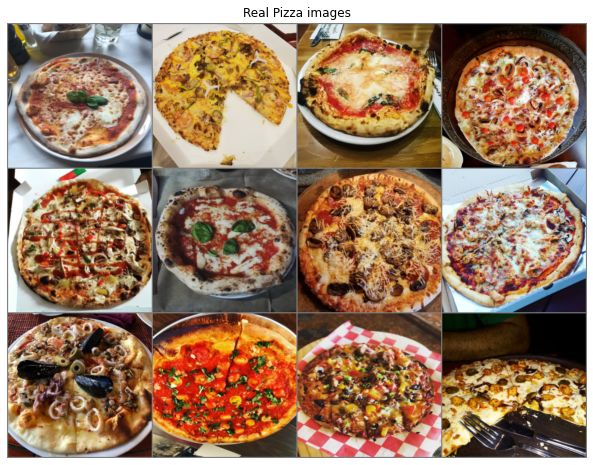

In [14]:
%matplotlib inline

def denorm(img_tensors):
    return img_tensors
def show_images(images, nmax=64):
    print(images.shape)
    # fig, ax = plt.subplots(figsize=(8, 8))
    # ax.set_xticks([]); ax.set_yticks([])
    # ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

    temp = make_grid(images, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
    temp = temp * 0.5 + 0.5
    temp = temp * 255.0
    temp = temp.astype(int)

    fig = plt.figure(figsize=(18, 8), facecolor='w')
    plt.imshow(temp)
    plt.axis('off')
    plt.title('Real Pizza images')
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(real_train_dl)

# Check for gpu and load data

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
real_train_dl = DeviceDataLoader(real_train_dl, device)


# Discriminator

In [16]:
# Discriminator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# C64 − C128 − C256 − C512

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # C64 − C128 − C256 − C512

        self.c64 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.c128 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)

        )
        self.c256 = nn.Sequential(
            nn.Conv2d(128, 256,kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.c512 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        
        # single output 
        self.single_cov = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    
    def forward(self, x):
        x = self.c64(x)
        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        x=self.single_cov(x)
        return x
        

In [17]:
# create the discriminator
discriminator = to_device(Discriminator(), device)

In [11]:
# prallelise the discriminator
discriminator = nn.DataParallel(discriminator, device_ids=[0,1,3])

# Generator

In [19]:
# Residual block
class Reisdual(nn.Module):
    
    def __init__(self, input):
        super(Reisdual, self).__init__()
        kernel =3
        stride=1
        relflection_padding = (kernel-1)//2
        padding=0

        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(padding=relflection_padding),
            nn.Conv2d(input, input, kernel_size=kernel, stride=stride, padding=padding),
            nn.InstanceNorm2d(input, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(padding=relflection_padding),
            nn.Conv2d(input, input, kernel_size=kernel, stride=stride, padding=padding),
            nn.InstanceNorm2d(input, affine=False, track_running_stats=False),
        )        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)        
        return x + residual

In [20]:


# genarator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# c7s1 − 64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1_3

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.c7s1_64 = self.c7s1_k_64(3, 64, 7, 1)
        self.d128 = self.d_k(64, 128, 3, 2)
        self.d256 = self.d_k(128, 256, 3, 2)
        self.R256 = self.residual_block(256)
        self.u128 = self.u_k(256, 128, 3, 2)
        self.u64 = self.u_k(128, 64, 3, 2)
        self.c7s1_3 = self.c7s1_k_3(64, 3, 7, 1)

                 
    
    # c7s1 − 64
    def c7s1_k_64(self, input, output, kernel, stride):
        reflection_padding = (kernel - 1) // 2
        padding=0
        module = nn.Sequential(
            nn.ReflectionPad2d(padding=reflection_padding),
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding),
            nn.InstanceNorm2d(output, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True)
        )

        return module


        return module
    #c7s1_3
    def c7s1_k_3(self, input, output, kernel, stride):
        reflection_padding = (kernel - 1) // 2
        padding=0
        return nn.Sequential(
            nn.ReflectionPad2d(padding=reflection_padding),
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding, bias=False),
        )

    # D128,D256
    def d_k(self, input, output, kernel, stride):
        padding=(kernel - 1) // 2
        # no reflection padding
        module = nn.Sequential(
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(output, affine=True),
            nn.ReLU(True)
        )
        return module
    
    # R256 Residual block defined above
    def residual_block(self, input):
        return Reisdual(input)

    
    # u128,u256
    def u_k(self, input, output, kernel, stride):
        module = nn.Sequential(
            nn.ConvTranspose2d(input, output, kernel_size=kernel,
                               stride=stride, padding=1, output_padding=1),
            nn.InstanceNorm2d(output, affine=False),
            nn.ReLU(inplace=True)
        )
        return module

    def forward(self, x):

        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)

        # 9 times residual block
        for i in range(9):
            x = self.R256(x)

        # u128
        x = self.u128(x)
        # u64
        x = self.u64(x)
        # c7s1_3
        x = self.c7s1_3(x)
        return x


In [21]:
# create the generator
generator = Generator()
generator = to_device(generator, device)

In [22]:
# parallelise the generator
generator = nn.DataParallel(generator, device_ids=[0,1,3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


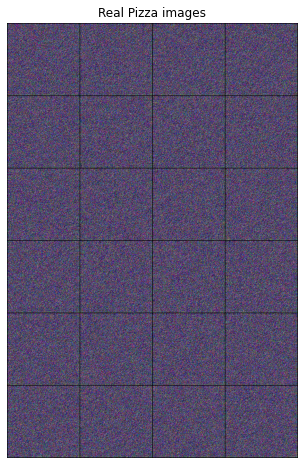

In [27]:
# test generator
# first create a generator
# then test it

# generate a random noise
z = torch.randn(batch_size, 3, 256, 256)
z=z.to(device)
# generate a fake image
fake_image = generator(z)

fake_image = fake_image * 0.5 + 0.5
fake_image = fake_image * 255.0

temp = make_grid(fake_image, nrow=4, padding=2).permute(1, 2, 0).detach().numpy().astype(int)


fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Real Pizza images')
plt.show()

# print(fake_image.shape)
# img_grid = vutils.make_grid(fake_image, padding=2, normalize=True, nrow=8).cpu()
# # show the fake image

# fig=plt.figure(figsize=(16, 16))
# plt.axis("off")
# plt.title("Generated real pizza images")
# plt.imshow(np.transpose(img_grid, (1, 2, 0)))
# fig.savefig('test_rl_no_tan.png')


# intialise weights

In [25]:
def init_weights(module):
    assert isinstance(module, nn.Module)
    if hasattr(module, "weight") and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if hasattr(module, "bias") and module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.0)
    for c in module.children():
        init_weights(c)

init_weights(generator) 
init_weights(discriminator)       

# Discriminator Training

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones_like(real_preds,device=device)

    real_loss = criterion(real_preds, real_targets)
    with torch.no_grad():
        real_score = mean_loss(real_preds).mean().item()
    

    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros_like(fake_preds,device=device)

    fake_loss = criterion(fake_preds, fake_targets)
    with torch.no_grad():
        fake_score = mean_loss(fake_preds).mean().item()
    
    # Update discriminator weights
    loss = (real_loss + fake_loss)/2
    loss.backward()
    opt_d.step()
    return loss.item(), real_score,fake_score

# Generator Training

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones_like(preds, device=device)
    loss = criterion(preds, targets)
    with torch.no_grad():
        fake_score_gen = mean_loss(preds).mean().item()


    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item(),fake_score_gen

# Save generated images

In [30]:
# save sample images 

def save_samples(epoch=1):
    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample).cpu().detach()
    fake_images = fake_images * 0.5 + 0.5
    fake_images = fake_images * 255.0
    img_grid = vutils.make_grid(fake_images, padding=2, normalize=True, nrow=8).detach().cpu().numpy().astype(int)

    fig=plt.figure(figsize=(16, 16))
    plt.axis("off")
    plt.title(f"Generated image of {epoch}")
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    fig.savefig(f'{samples_dir}/genrated_{epoch}.png')


# Training loop

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    fake_scores_g =[]

    loss_g=0
    loss_d=0
    real_score=0
    fake_score=0
    fake_score_g=0
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    batches = len(real_train_dl)
    
    discriminator.train()
    generator.train()
    
    for epoch in range(epochs):
        # for real_images, _ in tqdm(real_train_dl):
        for index, (real_images, _) in enumerate(real_train_dl):
            #print(len(real_images))
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g,fake_score_g = train_generator(opt_g)

            # Save losses & scores to summarywirter
            iters = index + epoch * batches + 1
            writer.add_scalar("Train_Adversarial/D_Loss", loss_d, iters)
            writer.add_scalar("Train_Adversarial/G_Loss", loss_g, iters)
            writer.add_scalar("Train_Adversarial/D_Real", real_score, iters)
            writer.add_scalar("Train_Adversarial/D_Fake_Discriminator", fake_score, iters)
            writer.add_scalar("Train_Adversarial/D_Fake_Genrator", fake_score_g, iters)
            
        # Record losses & scores to lists
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        fake_scores_g.append(fake_score_g)


        # Log losses & scores (last batch)
       # for every 5th epoch
        if epoch % 5 == 0:
         print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated imagess
        save_samples(epoch)
        # save model
        torch.save(discriminator.state_dict(), os.path.join(models_dir, f"discr_{epoch}.pth"))
        torch.save(generator.state_dict(), os.path.join(models_dir, f"genr_{epoch}.pth"))

    
    return losses_g, losses_d, real_scores, fake_scores,fake_scores_g

In [22]:
history = fit(epochs, lr)

Epoch [1/50], loss_g: 0.2678, loss_d: 0.2409, real_score: 0.6264, fake_score: 0.6215
Epoch [2/50], loss_g: 0.3245, loss_d: 0.2500, real_score: 0.6144, fake_score: 0.6089
Epoch [3/50], loss_g: 0.3907, loss_d: 0.1898, real_score: 0.6329, fake_score: 0.5951
Epoch [4/50], loss_g: 0.3070, loss_d: 0.2622, real_score: 0.6206, fake_score: 0.6237
Epoch [5/50], loss_g: 0.4526, loss_d: 0.2090, real_score: 0.6202, fake_score: 0.5890
Epoch [6/50], loss_g: 0.3084, loss_d: 0.2304, real_score: 0.6435, fake_score: 0.6290
Epoch [7/50], loss_g: 0.3664, loss_d: 0.2317, real_score: 0.6274, fake_score: 0.6115
Epoch [8/50], loss_g: 0.3628, loss_d: 0.2280, real_score: 0.6201, fake_score: 0.5995
Epoch [9/50], loss_g: 0.6438, loss_d: 0.2166, real_score: 0.6715, fake_score: 0.6326
Epoch [10/50], loss_g: 0.6454, loss_d: 0.1084, real_score: 0.6733, fake_score: 0.5757
Epoch [11/50], loss_g: 0.4834, loss_d: 0.1635, real_score: 0.6659, fake_score: 0.5992
Epoch [12/50], loss_g: 0.7663, loss_d: 0.2325, real_score: 0.65

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)
